<h2>Text Analysis of the Content from the 2018 Sensors Expo & Conference Program</h2>

<h3>Introduction</h3>

For the sake of brevity, I'm going to bypass the discussion of how I actually created the key datasets used in this analysis and begin the analysis with a scraped, cleaned, and edited collection of the program contents converted to a Python dictionary and stored locally as JSON file. I could have used some other format for storage (e.g. pickle) but choose JSON for it's readability and the ease with which JSON files can be converted to Mongodb collections. 

The file, labeled <i>progDict.json</i>, represents the key elements of the conference program -- tracks, sessions, talks and the names of the speakers giving those talks. Each of these elements has a textual component, including the track title, session title and session abstract, and the talk title. While natural language processing can be applied to each of these, our focus will be on the session abstracts.  The reason for this selection will be explained shortly.

A variety of terms could be used to describe the type of analysis performed in this notebook. The main candidates were:

<ul>
    <li><i>Natural Language Processing (NLP)</i> - "An area of research in computer science
and artificial intelligence (AI) concerned with processing natural languages
(e.g. English or Mandarin). It generally involves translating natural language into data (numbers) that a computer can use to learn about the world."</li>
    <li><i>Text Analysis</i> - Involves information retrieval, lexical analysis to study word frequency distributions, pattern recognition, tagging/annotation, information extraction, data mining techniques including link and association analysis, visualization, and predictive analytics. Essentially, the overarching goal is to turn text into data for analysis, via the application of natural language processing (NLP) and analytical methods.</li> 
    <li><i>Text Mining</i> or <i>Text Analytics</i> - A set of linguistic, statistical, and machine learning techniques that model and structure the information content of textual sources for business intelligence, exploratory data analysis, research, or investigation. It usually involves the process of structuring the input text, parsing it, deriving patterns within the structured data, and finally evaluating and interpreting the output.</li>
</ul>

Of these, I chose to use the term <i>Text Analysis</i>, although I could have just as easily used one of the other terms since they all involve roughly the same basic processes. The processes that are used in this notebook are summarized in the following Table of Contents:

<h3><a class="anchor" id="toc">Table of Contents</a></h3>

1. [Reading the Program JSON file and Converting it to a Dictionary](#jsonDict)<br>
   [Structure of the Program Dictionary: Nested Levels](#structure progdict)<br>
   [Nested Keys](#nested keys)<br>
   [Determining the Keys](#determine keys)<br>
2. [Selecting a Corpus](#select corpus)<br>
   [Track Titles](#track titles)<br>
   [Session and Talk Titles](#session and talk titles)<br>
   [Final Candidate: Session Abstracts](#session abstracts)<br>
   [Creating a Dictionary for Session Abstracts](#dictionary session abstracts)<br>
3. [Text Analysis of Session Abstracts](#text analysis)<br>
   [Process of Creating a Bag of Words](#bag of words)<br>
   [Tokenizing](#tokenize)<br>
   [Refining the Tokens](#refining)<br>
   [Converting to Lowercase](#lowercase)<br>
   [Eliminate Non-Alphanumerics](#alphanumerics)<br>
   [Eliminate Stopwords](#stopwords)<br>
   [Lemmatization](#lemmas)<br>
   [N-gram Analysis](#ngrams)<br>
4. [Creating the Bag of Words](#bows)<br>
   [Collection Counter](#counter)<br>
   [Counters for Bigrams and Trigrams](#bi tri counter)<br>
5. [Bigger Picture](#big picture)<br>
   [NLTK Frequency Distribution](#freq dist)<br>
   [Frequency Distribution of Lemmas](#freq dist of lemmas)<br>
   [Frequency Distribution of Bigrams](#freq dist of bigrams)<br>
6. [Next Steps in the Analysis](#next steps)<br>
   [Lemma Dictionary for Next Steps](#lemma dictionary)<br>
   

In [1]:
# this declaration enables multiple outputs from the cells in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a class="anchor" id="jsonDict"></a>
<h3> Reading the JSON Files and Converting them to Python Dictionaries</h3>
* [Return to TOC](#toc)

Because the program dictionary - progDict.json - is stored as a json file, we first need to import the json modules in order to simplify the handling of this format. Once this is done, the task of reading, subsequently loading, and automatically converting the contents of the file to a dictionary is extremely simple. 

In [2]:
import json
with open('progDict.json') as f:
   progDict = json.loads(f.read())

To verify that the loading and conversion has occurred, we can check the type of 'progDict', it's length (i.e. in this case the length is defined as the number of tracks in the program), and it's keys.

In [3]:
print('Type for progDict: ', type(progDict))
print('')
print('Number of Tracks: ', len(progDict))
print('')
print('Keys for Tracks in progDict:', list(progDict.keys()))

Type for progDict:  <class 'dict'>

Number of Tracks:  13

Keys for Tracks in progDict: ['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12']


<a class="anchor" id="structure progdict"></a>
<h3>Structure of the Program Dictionary: Nested Levels</h3>
* [Return to TOC](#toc)

This dictionary -- <i>progDict</i> -- is actually a nested hierarchy of dictionaries (sort of like a Russian Matryoshka doll). On the outside are the tracks. At the next layer are the sessions. On the inside are the talks. A complete listing of the structure and the fields associated with each level are shown below. 

<ol>
    <li>Conference Program</li>
        <ul>
        <li>progDict = {} # dictionary of program contents</li>
    </ul>
    <li>Tracks
        <ul>
        <li>progDict\[trkID\] = {} # dictionary for each track - 'trkID' (string) key</li>
        <li>progDict\[trkID\]\['trkTitle'\] # string containing the title of the track</li>
        </ul>
    </li>
    <li>Sessions
        <ul>
        <li>progDict\[trkID\]\['sessions'\] = {} # dictionary of sessions</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\] = {} # dictionary for each session - 'sessID' is the (string) key</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\['sessTitle'\] # string containing the title of the Session</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\['sessAbstract'\] # string containing the abstract describing the Session</li>
        </ul>
    </li>
    <li>Talks
        <ul>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\['sessTalks'\] = {} dictionary of sessTalks</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\['sessTalks'\][sessTalksID] = {} # dictionary for each talk - 'sessTalksID' is the (string) key</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\[sessID\]\['sessTalks'\]\[sessTalksID\]\['sessTalkTitle'\] # string containing title of the Talk</li>
        <li>progDict\[trkID\]\['sessions'\]\[sessID\]\['sessTalks'\]\[talkID\]\['sessTalkSpeakers'\] # list of strings containing the speakers names</li>
        </ul>
    </li>
</ol>


<a class="anchor" id="nested keys"></a>
<h4>Nested Keys</h4>
* [Return to TOC](#toc)
<p>
The keys for each level -- track, session and talk -- are relatively straight forward and reflect the nested structure:
<ol>
    <li><i>Track Keys</i> (trkID): 'Txx' where 'xx' runs from '00' to 'X-1' where X is number of tracks (e.g. 'T00' to 'T12').</li>
    <li><i>Session Keys</i> (sessID): 'SyyTxx' the key for sessions within a track where 'yy' runs from '00' to 'Y-1' where Y is the number of sessions in the track (e.g. 'S00T03' to 'S05T03'- track '03' has 6 sessions)</li>
    <li><i>Talk Keys</i> (talkID): 'TkzzSyyTxx' the key for talks within a session within a track where 'zz' runs from '00' to 'ZY-1' where Z is the number of talks with a session within a given track (e.g. 'TK00S00T03' to 'TK11S00T03' - session '00' in track '03' has 12 talks)</li>
</ol>

The keys could have taken any number of forms, as long as they remained unique. However, I wanted the keys to mirror the nested structure and to simplify their use with other programs without having to carry the added baggage of bringing along extra track and session info.  So, for example, the key for a talk makes it fairly easy to identify the associated session and track without having to query either of those entities.

<a class="anchor" id="determine keys"></a>
<h4>Determining the Keys</h4>
* [Return to TOC](#toc)
<p>
In traversing the various levels and hiearchies it is important to remember that different tracks have differing numbers of sessions and differing sessions have differing numbers of talks and that the session and talk keys or IDs are not sequenced across the entire set of sessions or talks. Even though there is variation in the 'ID' structures, there is no variation in the other fields associated with the tracks, sessions and talks. That is, all tracks have a title, all sessions have a title and abstract, and all talks have a title and speakers.

Given these factors, the following examples illustrate how to extract the keys and associated fields at the various levels:

In [4]:
# The following examples all assume the following IDs for the track, session and talk
trkID = 'T03'
sessID = 'S00T03'
talkID = 'TK00S00T03'

In [5]:
print('The keys for the programs are actually the tracks around which the program is organized')
progDict.keys()

The keys for the programs are actually the tracks around which the program is organized


dict_keys(['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12'])

In [6]:
print('Field names for a given track -- T03')
progDict[trkID].keys()

Field names for a given track -- T03


dict_keys(['trkTitle', 'sessions'])

In [7]:
print('Title for a given track -- T03')
progDict[trkID]['trkTitle']

Title for a given track -- T03


'Energy Harvesting & Power'

In [8]:
print('IDs for all sessions in a given track -- T03')
progDict[trkID]['sessions'].keys()

IDs for all sessions in a given track -- T03


dict_keys(['S00T03', 'S01T03', 'S02T03', 'S03T03', 'S04T03', 'S05T03'])

In [9]:
print('Field names for a given session in a given track -- S00 in T03')
progDict[trkID]['sessions'][sessID].keys()

Field names for a given session in a given track -- S00 in T03


dict_keys(['sessTitle', 'sessAbstract', 'sessTalks'])

In [10]:
print('List title for a given session and track -- S00 in T03')
progDict[trkID]['sessions'][sessID]['sessTitle']

List title for a given session and track -- S00 in T03


'Pre-Conference Symposium 3 - Democratizing IoT - Connecting Technology with People'

In [11]:
print('IDs for all talks in given session in a given track -- S00 in T03')
progDict[trkID]['sessions'][sessID]['sessTalks'].keys()

IDs for all talks in given session in a given track -- S00 in T03


dict_keys(['TK00S00T03', 'TK01S00T03', 'TK02S00T03', 'TK03S00T03', 'TK04S00T03', 'TK05S00T03', 'TK06S00T03', 'TK07S00T03', 'TK08S00T03', 'TK09S00T03', 'TK10S00T03', 'TK11S00T03'])

In [12]:
print('Field names for a given talk in a given session and a given track - TK00 in S00 in T03')
progDict[trkID]['sessions'][sessID]['sessTalks'][talkID].keys()

Field names for a given talk in a given session and a given track - TK00 in S00 in T03


dict_keys(['talkTitle', 'talkSpeakers'])

In [13]:
print('List speakers for a given talks in a given session and track -- T00 in S00 in T03')
progDict[trkID]['sessions'][sessID]['sessTalks'][talkID]['talkSpeakers']

List speakers for a given talks in a given session and track -- T00 in S00 in T03


['Dominic Pajak']

<a class="anchor" id="select corpus"></a>
<h3>Selecting a Corpus</h3>
* [Return to TOC](#toc)
<p>

With this background, we're ready to extract a corpus of text items for analysis. The ultimate goal is to understand from a content perspective what the Sensors Expo and Conference is all about -- key ideas and topics being discussed.

In this dictionary there are essentially 4 entries that are textual in nature:

<ul>
    <li>Track Titles: trksDict[trkID]['trkTitle']</li>
    <li>Session Titles: trksDict[trkID]['sessions'][sessID]['sessTitle']</li>
    <li>Session Abstracts: trksDict[trkID]['sessions'][sessID]['sessAbstract']</li>
    <li>Talk Titles: trksDict[trkID]['sessions'][sessID]['sessTalks'][talkID]['talkTitle']</li>
</ul>

A quick look at some sample titles and abstracts provides a quick understanding of which of these items offers a reasonable overview of the conference content.

<a class="anchor" id="track titles"></a>
<h4>Track Titles</h4>
* [Return to TOC](#toc)

In [14]:
print('List of track titles:')
print('')
for trkID in list(progDict.keys()):
    print(progDict[trkID]['trkTitle'])
    

List of track titles:

Keynote Presentations
Pre-Conference Designing for the Industrial & Embedded IoT
MEMS & Sensors
Energy Harvesting & Power
IoT & Wireless
Flexible & Wearable
IoT Ecosystem
Designing for the Industrial & Embedded IoT
Machine Learning & AI
Sensor Applications
Simplifying Complex Sensor Data
Measurement & Detection
Optical Sensing & Detection


Based solely on the words in the track titles, it's easy to see that the 2018 conference probably had quite a bit to do with sensors (which is obvious) and IoT, and to a lesser extent with concepts like detection, MEMS, wireless, wearables, machine learning, AI, etc. Yet, because there are varying numbers of sessions in each track and varying numbers of talks in each session, there is no way of knowing just from this list of titles how pervasive these terms and concepts are throughout the entire conference.

One simple way to do this is by looking at these numbers of sessions and talks associated with each track.  This is done below:

In [15]:
print('List of track titles with associated numbers of sessions and talks:')
print('')
sessCnt = 0
sessCumCnt = 0
talkCumCnt = 0
for trkID in list(progDict.keys()):
    title = progDict[trkID]['trkTitle']
    sessCnt = len(progDict[trkID]['sessions'])
    sessCumCnt += sessCnt
    talkCnt = 0
    for sessID in list(progDict[trkID]['sessions'].keys()):
        talkCnt += len(progDict[trkID]['sessions'][sessID]['sessTalks'])
    talkCumCnt += talkCnt
    trkStr = trkID + ' ' + title + ' (' + str(sessCnt) + ',' + str(talkCnt) + ')'
    print(trkStr)
print('')
print('Total Sessions', sessCumCnt, 'Total Talks', talkCumCnt)

List of track titles with associated numbers of sessions and talks:

T00 Keynote Presentations (6,6)
T01 Pre-Conference Designing for the Industrial & Embedded IoT (1,12)
T02 MEMS & Sensors (6,13)
T03 Energy Harvesting & Power (6,17)
T04 IoT & Wireless (10,26)
T05 Flexible & Wearable (5,5)
T06 IoT Ecosystem (1,1)
T07 Designing for the Industrial & Embedded IoT (15,15)
T08 Machine Learning & AI (5,5)
T09 Sensor Applications (40,43)
T10 Simplifying Complex Sensor Data (4,4)
T11 Measurement & Detection (4,4)
T12 Optical Sensing & Detection (29,29)

Total Sessions 132 Total Talks 180


A bit of crude math verifies the first inclinations. We would expect a conference about sensors to have a lot of discussion about sensors, which is reflected in these titles and counts. In total, 79 sessions out of 132 sessions and 90 talk out of 181 talks came from tracks with the term "Sensor(s)" or 'sensing" in the title.  Following the same logic, 'IoT' was associated with 27 sessions and 54 talks, 'Detection' with 33 sessions and 33 talks, 'Industrial' with 16 sessions and 27 talks, etc. Yet, even these number tell us little about the breadth of the terms, concepts and topics covered by the 132 sessions and 180 talks. Better indicators are provided by the titles associated with these segments.

<a class="anchor" id="session and talk titles"></a>
<h4>Session and Talk Titles</h4>
* [Return to TOC](#toc)

Before we look at these titles, it's important to note that in many cases the ratio of the number of sessions and the number of talks in a track is basically 1 to 1. For instance, in the 'Keynote Track' (T01) it's 7 to 7, or in Optical Sensing and Detection (T12) it's 29 to 29. In fact, this is the case in 8 out of 12 tracks. In all of these cases, the session and the talk, and thus their titles, are one in the same. The point is, that the talk titles: (1) encompass the session titles; and (2) are more varied than the session titles. For this reason there's no need to look at the session titles separately.

To get a general sense of what the talk titles look like, let's examine a short list. The list is generated by putting all the titles in a dictionary (labeled 'talkTitles') and then looking (arbitrarily) at every 25th entry.

In [16]:
talkTitles = {}
for tID in list(progDict.keys()):
    for sID in list(progDict[tID]['sessions'].keys()):
        for tkID in list(progDict[tID]['sessions'][sID]['sessTalks'].keys()):
            talkTitles[tkID] = {}
            talkTitles[tkID] = progDict[tID]['sessions'][sID]['sessTalks'][tkID]['talkTitle']

titleCnt = 0
for tkID in list(talkTitles.keys()):
    if titleCnt%25 == 0:
        print(tkID + ':')
        print(talkTitles[tkID])
        print("")
    titleCnt += 1

TK00S00T00:
Keynote Presentation - Embedded Hands-On Workshop - Prototype an IoT Sensor Node with a Microchip MPLAB Xpress Eval Board

TK07S00T02:
Techniques and the Methodology for Reducing Processing System Power in Energy Harvesting Applications

TK02S00T04:
Design Considerations and Manufacturing Process Tradeoffs for the Creation of Printed Sensors and Sensor-Based Systems

TK00S01T05:
IoT6 - IoT Voice & Sensor Use Cases and Solutions

TK00S00T09:
STMicro Hands-On Workshop - Rapid Prototyping with MEMS Sensors and Microcontrollers - A Hands-On Workshop Introducing the ST AlgoBuilder

TK00S22T09:
Low Power Microheater Based Platform fir Toxic Gas Sensing

TK00S03T11:
O4 - Spectrometer Technology & Applications

TK00S24T12:
Securing Your IoT Solution



These titles are certainly more extensive and expressive than the track titles. On the surface, it looks like they might provide a reasonable representation of the overall content.

<a class="anchor" id="session abstracts"></a>
<h4>Final Candidate: Session Abstracts</h4>
* [Return to TOC](#toc)

The final candidate for analysis is the <i>session abstracts</i>. Again, we'll examine a short list using basically the same procedures, except we'll only review a couple because of their length.

In [17]:
sessAbstracts = {}
for tID in list(progDict.keys()):
    for sID in list(progDict[tID]['sessions'].keys()):
        sessAbstracts[sID] = progDict[tID]['sessions'][sID]['sessAbstract']

print('Small Sample of Session Abstracts')
print('')
for sID in list(sessAbstracts.keys()):
    if sessCnt % 30 == 0:
        print(sID + ':')
        print(sessAbstracts[sID])
        print('')
    sessCnt += 1
print('****')

Small Sample of Session Abstracts

S01T00:
Computer vision is enabling many of the world's most exciting new technologies, such as autonomous vehicles and robots, AI, and a wide range of IoT-centric applications. And advanced sensing capabilities are key to the continued development of these vision-enabled systems. Attend this Keynote Session and examine how sensors are being exploited in mixed and augmented reality applications, including 3D modeling, image and video analysis, gesture recognition, scene understanding, and power-efficient embedded computing. Join us as Marc discusses the use of these technologies in the development of Microsoft's groundbreaking HoloLens and shares his vision on the future of information access and machine-enabled human interaction.

S02T05:
The IoT industry, forecasted to reach $14.2T by 2030, is unlike any other technology evolution from recent history. Meaning IoT networks must be built with future growth, additional use cases, and performance in min

Looking at these examples, it appears that each abstract is like a mini summary of the general content of the talks (which is what they're supposed to be).  Given that there are 132 of them and there 180 talks, this provides substantial coverage for the basic content of the talks in the conference. For this reason, the detailed text analysis that follows it focused on the corpus of session abstracts.
<p>
The dictionary that was just created offers the starting point for the analysis. However, I'm going to change the structure modestly so that we can add additional fields to each session based on the results of various forms of textual and lexical analysis.

<a class="anchor" id="dictionary session abstracts"></a>
<h4>Creating a Dictionary for Session Abstracts</h4>
* [Return to TOC](#toc)

Each entry in the sessAbstracts dictionary (i.e. sessAbstractsDict) has a session key (e.g. S00T00) along with the text of the abstract.  While this offers simple access to the abstracts, we're going to modify the dictionary so that we
can add additional analytical results to each session.

The modified version looks like this:

In [18]:
print('Dictionary for Session Abstracts')
print('')

sessAbstractsDict = {}
for sID in list(sessAbstracts.keys()):
    sessAbstractsDict[sID] = {}
    sessAbstractsDict[sID]['sessAbstract'] = sessAbstracts[sID]
    
print('Length of sessAbstractsDict: ', len(sessAbstractsDict))
print('')
print('First 10 keys in sessAbstractsDict')
print(list(sessAbstractsDict.keys())[0:10])

Dictionary for Session Abstracts

Length of sessAbstractsDict:  132

First 10 keys in sessAbstractsDict
['S00T00', 'S01T00', 'S02T00', 'S03T00', 'S04T00', 'S06T00', 'S00T01', 'S00T02', 'S01T02', 'S02T02']


<a class="anchor" id="text analysis"></a>
<h3>Text Analysis of Session Abstracts: NLP Processing</h3>
* [Return to TOC](#toc)

As noted in the introduction, "the overarching goal (of text analysis) is to turn text into data for analysis, via application of natural language processing (NLP) and analytical methods. There are a variety of ways to apply NLP in this case.  For Python the most obvious way is to employ the analytical capabilities provided by the <a href ="https://www.nltk.org/"><i>Natural Language Toolkit (NLTK)</i></a>. 

In the words of the nltk.org, the NLTK is:

<p style="margin-left: 40px">
A collection of text "over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum."
</p>

The toolkit has been under active development since 2005. In 2009 the toolkit was popularized by the publication of:

<p style="margin-left: 40px">
<i>Natural Language Processing with Python</i>, by Steven Bird, Ewan Klein and Edward Loper, has been published by O’Reilly Media Inc.
</p>

The publication is available from O'Reilly, as well as Amazon.  It is also available online at http://www.nltk.org/book/. 
In 2014-5, the online version was updated to comply with Python 3.+ and NLTK 3. An overview of the general capabilities of the NLTK is shown below: 


<table>
     <tr><th>Language processing task</th> <th>NLTK modules</th><th>Functionality</th></tr>
     <tr><td>Accessing corpora</td><td>corpus</td><td>standardized interfaces to corpora and lexicons</td></tr>
    <tr><td>String processing</td><td>tokenize, stem</td><td>tokenizers, sentence tokenizers, stemmers</td></tr>
    <tr><td>Collocation discovery</td><td>collocations</td><td>t-test, chi-squared, point-wise mutual information</td></tr>
    <tr><td>Part-of-speech tagging</td><td>tag</td><td>n-gram, backoff, Brill, HMM, TnT</td></tr>
    <tr><td>Machine learning</td><td>classify, cluster, tbl</td><td>decision tree, maximum entropy, naive Bayes, EM, k-means</td></tr>
    <tr><td>Chunking</td><td>chunk</td><td>regular expression, n-gram, named-entity</td></tr>
    <tr><td>Parsing</td><td>parse, ccg</td><td>chart, feature-based, unification, probabilistic, dependency</td></tr>
    <tr><td>Semantic interpretation</td><td>sem, inference</td><td>lambda calculus, first-order logic, model checking</td></tr>
    <tr><td>Evaluation metrics</td><td>metrics</td><td>precision, recall, agreement coefficients</td></tr>
    <tr><td>Probability and estimation</td><td>probability</td><td>frequency distributions, smoothed probability distributions</td></tr>
    <tr><td>Applications</td><td>app, chat</td><td>graphical concordancer, parsers, WordNet browser, chatbots</td></tr></th>
    <tr><td>Linguistic fieldwork</td><td>toolbox</td><td>manipulate data in SIL Toolbox format</td></tr>
</table>

Initially, the main capabilities we'll be using are the corpus, string processing, collocation and probability modules from the library.

Assuming that the NLTK library has been installed on your system, to access these capabilities we need to either import the library or specific modules and functions within the library. To simplify the discussion, we're going to import the whole library.

In [19]:
import nltk

At the end of these initial steps, the primary goal is to convert:
<ol> 
    <li>Each abstract in the collection of abstracts (our corpus) from an English statement to a data representation called a <i>bag of words (BOW)</i>. A <i>BOW</i> is a word frequency vector indicating the set of unique words or terms in the abstract along with the frequency with which each occurs. In Python one way to represent the BOW is with a dictionary (e.g. {'Sensor':2, 'IoT': 1, ...}).</li>
    <li>The whole corpus of abstracts to a <i>document-term matrix</i> where the rows represent a single abstract (document), the columns represent the words or terms used in the corpus (i.e. the vocabular), and the cells indicate how frequently a term occurs in an given abstract.</li>
</ol>
        
Once converted, we can begin to model or mine the corpus in a variety of ways (e.g. determining the underlying topics).

<a class="anchor" id="bag of words"></a>
<h4>Process of Creating a Bag of Words</h4>
* [Return to TOC](#toc)

<a class="anchor" id="tokenize"></a>
<h5>Tokenizing</h5>
* [Return to TOC](#toc)

The first step in creating a BOW for each abstract is to <i>tokenize</i> the abstract. Essentially, tokenization splits text into individual tokens where the tokens can be paragraphs, sentences, or individual words or terms (including potentially punctuation marks). Our focus is the latter, individual words or terms.

The NLTK tokenize module provides a number of <i>tokenizers</i>. Here is a list of a few:

<ul>
<li><i>WhitespaceTokenizer</i></li>
<li><i>WordPunctTokenizer</i></li>
<li><i>RegexpTokenizer</i></li>
<li><i>TreebankWordTokenizer</i></li>
</ul>

To use any tokenizer, we first have to import it. Next, we declare it as a object. Finally, we use the tokenize method to split the text entry into tokens.  The following illustrates the process for each of the tokenizers listed above. This provides a straightforward way to see some of the differences among them. In this particular set of examples, the differences include variations in how the various phrases like 'MEMS/Sensor', 'R&D', 'Hi-Tech' are treated and how some of the punctuation marks (such as slashes, commas, periods, ampersands and hyphens) are handled.

In [20]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer

wsTokenizer = WhitespaceTokenizer()
wpTokenizer = WordPunctTokenizer()
regTokenizer = RegexpTokenizer(r'\w+|$[0-9.]+|\S+')
tbankTokenizer = TreebankWordTokenizer()

sAbs = sessAbstractsDict['S05T07']['sessAbstract']

print('S05T07 Abstract: ', sAbs)
print('')
print('wsTokenizer: ',wsTokenizer.tokenize(sAbs))
print('')
print('wpTokenizer: ',wpTokenizer.tokenize(sAbs))
print('')
print('regTokenizer: ',regTokenizer.tokenize(sAbs))
print('')
print('tbankTokenizer: ',tbankTokenizer.tokenize(sAbs))


S05T07 Abstract:  The MEMS/SENSORS FORUM – Ho Chi Minh City is gathering and calling for investments and collaborations in R&D, training, technology transfer and manufacturing for MEMS industry in Saigon Hi-Tech Park, Ho Chi Minh City – Vietnam. Welcome to the MEMS/SENSORS FORUM 2018- Ho Chi Minh City on September 28, 2018 for further business exchanges.

wsTokenizer:  ['The', 'MEMS/SENSORS', 'FORUM', '–', 'Ho', 'Chi', 'Minh', 'City', 'is', 'gathering', 'and', 'calling', 'for', 'investments', 'and', 'collaborations', 'in', 'R&D,', 'training,', 'technology', 'transfer', 'and', 'manufacturing', 'for', 'MEMS', 'industry', 'in', 'Saigon', 'Hi-Tech', 'Park,', 'Ho', 'Chi', 'Minh', 'City', '–', 'Vietnam.', 'Welcome', 'to', 'the', 'MEMS/SENSORS', 'FORUM', '2018-', 'Ho', 'Chi', 'Minh', 'City', 'on', 'September', '28,', '2018', 'for', 'further', 'business', 'exchanges.']

wpTokenizer:  ['The', 'MEMS', '/', 'SENSORS', 'FORUM', '–', 'Ho', 'Chi', 'Minh', 'City', 'is', 'gathering', 'and', 'calling',

The 'whitespaceTokenizer' is the simplest and, as the name implies, treats everything between the white spaces as tokens. In this case, any punctuation mark that isn't surrounded by spaces will be included with the preceeding word. For example, after white space tokenization the following phrases 'FORUM - Ho' and 'Hi-Tech' will become 'FORUM', '-', 'Ho' and 'Hi-Tech', respectively .

In contrast, the 'WordPunctTokenizer, treats all punctuation as separate tokens. In the hands of this tokenizer the same phrases both end up with 3 tokens, i.e. 'FORUM', '-', 'Ho' and 'Hi', '-', 'Tech'. The same thing happens with 'R&D' which becomes 'R', '&', 'D'.

With the 'RegexpTokenizer' the results depend on the regular expression designated with the tokenizer.  Here, the user has entered a regex which basically creates tokens out of any alphabetic sequence '\w+', or money expressions '$\[0-9.\]+', or any other non-whitespace sequences '\S+'. One of the oddities with this particular expression is that it handles alphabetic sequences first and non-whitespace sequences after that. The impact is that phrases like Hi-Tech and R&D become 'Hi','-Tech', and 'R','&D', respectively.

Finally, the 'TreebankWordTokenizer' tokenizer combines the capabilites of the other three plus considerably more. It's actually a collection of regex tokenizers combined into one method or function. The results are pretty straightforward except for '2018-'. This probably occurred because of an error since the hyphen with 2018 should have been preceeded by a whitespace in the original abstract.

Note: For the un-initiated, the acronym MEMS refers to a 'micro-electromechanical system' which is a "process technology used to create tiny integrated devices or systems that combine mechanical and electrical components."

Given the results, I've opted to use the TreebankWordTokenizer. The following code produces a list of tokens from the abstract for each session and stores the list in new field in the sessAbstractDict. A few examples of the results of the Treebank tokenization process are also provided.

In [21]:
for sID in list(sessAbstractsDict.keys()):
    tokenList = tbankTokenizer.tokenize(sessAbstractsDict[sID]['sessAbstract'])
    sessAbstractsDict[sID]['sessAbstractTokens'] = tokenList
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sID, ':')
    print(sessAbstractsDict[sID]['sessAbstractTokens'])
    print('')

S03T00 :
['New', 'architectural', 'approaches', 'must', 'be', 'adopted', 'to', 'accommodate', 'the', 'sheer', 'volume', 'of', 'data', 'generated', 'by', 'billions', 'of', 'networked', 'sensors', 'in', 'addition', 'to', 'providing', 'flexibility', 'in', 'how', 'collected', 'data', 'is', 'integrated', ',', 'analyzed', 'and', 'monetized', 'as', 'part', 'of', 'the', 'broader', 'IoT', 'ecosystem.', 'This', 'session', 'explores', 'the', 'concept', 'of', 'extending', 'cloud-native', 'principles', 'to', 'the', 'network', 'edge', 'to', 'address', 'these', 'needs', 'as', 'well', 'as', 'outline', 'how', 'the', 'open', 'source', 'EdgeX', 'Foundry', 'project', 'is', 'aligned', 'to', 'this', 'paradigm', 'with', 'the', 'goal', 'of', 'simplifying', 'how', 'sensors', 'connect', 'to', 'an', 'interoperable', 'ecosystem', 'of', 'distributed', 'computing', 'applications', '.']

S04T00 :
['This', 'Keynote', 'Session', 'examines', 'innovative', 'concepts', 'and', 'technologies', 'aimed', 'at', 'the', 'search

<a class="anchor" id="refining"></a>
<h5>Refining the Tokens: Text Normalization</h5>
* [Return to TOC](#toc)

While the 'raw' tokens could be used to create a token count for each abstract, there are a number of adjustments that should be, and usually are, made to the raw tokens.  Collectively, these adjustments come under the heading of <i>text normalization</i>. Text normalization has also be labelled </i>text cleaning</i> or <i>text pre-processing</i>. The basic idea is to eliminate superfluous tokens (e.g., punctuation marks like '.' or ',' or words like 'of' and 'the', etc.) and to reduce the tokens to their canonical form so that similar words with minor differences are treated similarly (e.g. converting the tokens 'sensor', 'sensors', and 'Sensors' to the same root 'sensor.). There are a large number of normalization processes that could be included. For this purpose, we'll do the following:

   <li><i>Case</i> - What should we do about the 'case' of the tokens? Should we treat capitalized tokens/words differently than lower case (e.g. 'The' vs. 'the')? Usually the answer is no. So, the list of tokens is typically converted to lowercase.</li><br>
    <li><i>Non-alphanumeric tokens</i> - A sizeable number of the tokens are simply standalone punctuation marks. In this case (but not all cases), they provide little value to our understanding of the content of the conference program. For this reason, they should be eliminated from the lists. This still leaves punctuation like hypens and apostrophes/quotes which are not standalone</li><br>
    <li><i>Stopwords</i> - A <i>stopword</i> is a commonly used word that in many cases provides little value to the understanding of the content. Words like 'a', 'and', 'the', 'for', etc. predominate the English language but in this case offer little understanding about the actual content of the conference.  The results is that we usually (but not always) eliminate these from the token lists.</li><br>
    <li><i>Stems</i> and or <i>Lemmas</i> - "Another common vocabulary normalization technique is to eliminate the small meaning differences produced by pluralization or possessive endings of words, or even various verb forms." This normalization, identifying a common stem among various forms of a word, is called <i>stemming</i>. For example, 'sensors' and 'sensor' share the same stem 'sensor.' Or, 'provide', 'provides', 'provided', and 'providing' all have the same stem 'provid'. As this last example indicates, the result of stemming does not have to be a 'proper' word. In contrast, "<i>Lemmatization</i> is a more accurate way to normalize a word than stemming ... because it takes into account a word’s meaning. Lemmatization identifies words that mean similar things and groups them together so that they can all be treated as the same token or symbol by subsequent stages of the pipeline." Unlike stemming, lemmatization results in a root word. In order to carry out lemmatization, you generally have to know the word's <i>part of speech (POS)</i> because it can affect the meaning and thus the root. Thus, the lemma for 'sensors' and 'sensor' will be 'sensor', as long as the lemmization routine recognizes that these are nouns. Otherwise, the lemmas will remain 'sensor' and 'sensors'. Similarly, the lemmas for 'sense' and 'sensing' will be 'sense', as long as they are recognized as verbs.  

In the cells that follow, each of these processes is performed. They are carried out in a stepwise fashion with the results of each process feeding into the next. Along the way, I prefer to store the results along the way largely because I often find that I later encounter a task that requires these immediate results. So, first the tokens are converted to lowercase. Next, the non-alphanumeric tokens are eliminated from the lowercase tokens. From there, stopwords are deleted from the alphanumeric tokens. Finally, the alphanumeric tokens are lemmitized. The stepwise results are stored in a series of fields for each abstract so the overall collection becomes:

<ul>
    <li>sessAbstractsDict[sID]['sessAbstract']</li>
    <li>sessAbstractsDict[sID]['sessAbstractTokens']</li>
    <li>sessAbstractsDict[sID]['sessAbstractLowers']</li>
    <li>sessAbstractsDict[sID]['sessAbstractAlphaNums']</li>
    <li>sessAbstractsDict[sID]['sessAbstractNonStops']</li>
    <li>sessAbstractsDict[sID]['sessAbstractLemmas']</li>
</ul>

While the presentation that follows makes the process look a bit disjointed, this whole pipeline is usually constructed with one function or method.

<a class="anchor" id="lowercase"></a>
<h5>Converting to Lowercase</h5>
* [Return to TOC](#toc)

In [22]:
print('Case Normalization: Session Key and Number of Resulting Tokens')
print('')
for sID in list(sessAbstractsDict.keys()):
    lowerCaseList = [w.lower() for w in sessAbstractsDict[sID]['sessAbstractTokens']]
    sessAbstractsDict[sID]['sessAbstractLowers'] = lowerCaseList
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractLowers']))
    print(sessAbstractsDict[sID]['sessAbstractLowers'])
    print('')

Case Normalization: Session Key and Number of Resulting Tokens

S03T00 : 91
['new', 'architectural', 'approaches', 'must', 'be', 'adopted', 'to', 'accommodate', 'the', 'sheer', 'volume', 'of', 'data', 'generated', 'by', 'billions', 'of', 'networked', 'sensors', 'in', 'addition', 'to', 'providing', 'flexibility', 'in', 'how', 'collected', 'data', 'is', 'integrated', ',', 'analyzed', 'and', 'monetized', 'as', 'part', 'of', 'the', 'broader', 'iot', 'ecosystem.', 'this', 'session', 'explores', 'the', 'concept', 'of', 'extending', 'cloud-native', 'principles', 'to', 'the', 'network', 'edge', 'to', 'address', 'these', 'needs', 'as', 'well', 'as', 'outline', 'how', 'the', 'open', 'source', 'edgex', 'foundry', 'project', 'is', 'aligned', 'to', 'this', 'paradigm', 'with', 'the', 'goal', 'of', 'simplifying', 'how', 'sensors', 'connect', 'to', 'an', 'interoperable', 'ecosystem', 'of', 'distributed', 'computing', 'applications', '.']

S04T00 : 186
['this', 'keynote', 'session', 'examines', 'innova

<a class="anchor" id="alphanumerics"></a>
<h5>Eliminate Non-Alphanumerics</h5>
* [Return to TOC](#toc)

In [23]:
import re

print('AlphaNumeric Normalization: Session ID and Number of Tokens')
print('')

for sID in list(sessAbstractsDict.keys()):
    lowerCaseList = sessAbstractsDict[sID]['sessAbstractLowers']
    alphaNumsList = [re.sub(r"[^a-zA-Z0-9\-]","", word) for word in lowerCaseList ]
    alphaNumsList = [w for w in alphaNumsList if not w in ['-','--', ' ', '']]
    sessAbstractsDict[sID]['sessAbstractAlphaNums'] = alphaNumsList
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractAlphaNums']))
    print(sessAbstractsDict[sID]['sessAbstractAlphaNums'])
    print('')

AlphaNumeric Normalization: Session ID and Number of Tokens

S03T00 : 89
['new', 'architectural', 'approaches', 'must', 'be', 'adopted', 'to', 'accommodate', 'the', 'sheer', 'volume', 'of', 'data', 'generated', 'by', 'billions', 'of', 'networked', 'sensors', 'in', 'addition', 'to', 'providing', 'flexibility', 'in', 'how', 'collected', 'data', 'is', 'integrated', 'analyzed', 'and', 'monetized', 'as', 'part', 'of', 'the', 'broader', 'iot', 'ecosystem', 'this', 'session', 'explores', 'the', 'concept', 'of', 'extending', 'cloud-native', 'principles', 'to', 'the', 'network', 'edge', 'to', 'address', 'these', 'needs', 'as', 'well', 'as', 'outline', 'how', 'the', 'open', 'source', 'edgex', 'foundry', 'project', 'is', 'aligned', 'to', 'this', 'paradigm', 'with', 'the', 'goal', 'of', 'simplifying', 'how', 'sensors', 'connect', 'to', 'an', 'interoperable', 'ecosystem', 'of', 'distributed', 'computing', 'applications']

S04T00 : 178
['this', 'keynote', 'session', 'examines', 'innovative', 'concep

<a class="anchor" id="stopwords"></a>
<h5>Eliminate Stopwords</h5>
* [Return to TOC](#toc)

In [24]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
  
for sID in list(sessAbstractsDict.keys()):
    alphaNumsList = sessAbstractsDict[sID]['sessAbstractAlphaNums']
    nonStopsList = [w for w in alphaNumsList if not w in stop_words]
    nonStopsList = [w for w in nonStopsList if len(w) > 1]
    sessAbstractsDict[sID]['sessAbstractNonStops'] = nonStopsList
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractNonStops']))
    print(sessAbstractsDict[sID]['sessAbstractNonStops'])
    print('')

S03T00 : 53
['new', 'architectural', 'approaches', 'must', 'adopted', 'accommodate', 'sheer', 'volume', 'data', 'generated', 'billions', 'networked', 'sensors', 'addition', 'providing', 'flexibility', 'collected', 'data', 'integrated', 'analyzed', 'monetized', 'part', 'broader', 'iot', 'ecosystem', 'session', 'explores', 'concept', 'extending', 'cloud-native', 'principles', 'network', 'edge', 'address', 'needs', 'well', 'outline', 'open', 'source', 'edgex', 'foundry', 'project', 'aligned', 'paradigm', 'goal', 'simplifying', 'sensors', 'connect', 'interoperable', 'ecosystem', 'distributed', 'computing', 'applications']

S04T00 : 111
['keynote', 'session', 'examines', 'innovative', 'concepts', 'technologies', 'aimed', 'search', 'life', 'solar', 'system', 'repeated', 'cycles', 'freezing', 'melting', 'water', 'occurred', 'throughout', 'mars', 'history', 'represent', 'potentially', 'habitable', 'environment', 'search', 'modern', 'life', 'session', 'also', 'examines', 'potentially', 'habitab

<a class="anchor" id="lemmas"></a>
<h5>Lemmatization</h5>
* [Return to TOC](#toc)

In [25]:
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

wnl = nltk.WordNetLemmatizer()

def lemmatize_all(tokens):
    for word, tag in pos_tag(tokens):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

for sID in list(sessAbstractsDict.keys()):
    nonStopsList = sessAbstractsDict[sID]['sessAbstractNonStops']
    lemmas = lemmatize_all(nonStopsList)
    lemmaStr = ' '.join(lemmas)
    lemmaList = lemmaStr.split()
    sessAbstractsDict[sID]['sessAbstractLemmas'] = lemmaList
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sessAbstractsDict[sID]['sessAbstractLemmas'])
    print('')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\davek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\davek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

['new', 'architectural', 'approach', 'must', 'adopt', 'accommodate', 'sheer', 'volume', 'data', 'generate', 'billion', 'networked', 'sensor', 'addition', 'provide', 'flexibility', 'collect', 'data', 'integrate', 'analyzed', 'monetized', 'part', 'broad', 'iot', 'ecosystem', 'session', 'explore', 'concept', 'extend', 'cloud-native', 'principle', 'network', 'edge', 'address', 'need', 'well', 'outline', 'open', 'source', 'edgex', 'foundry', 'project', 'align', 'paradigm', 'goal', 'simplify', 'sensor', 'connect', 'interoperable', 'ecosystem', 'distribute', 'compute', 'application']

['keynote', 'session', 'examines', 'innovative', 'concept', 'technology', 'aim', 'search', 'life', 'solar', 'system', 'repeat', 'cycle', 'freeze', 'melt', 'water', 'occur', 'throughout', 'mar', 'history', 'represent', 'potentially', 'habitable', 'environment', 'search', 'modern', 'life', 'session', 'also', 'examine', 'potentially', 'habitable', 'environment', 'solar', 'system', 'icy', 'satellite', 'jupiter', 'sa

<a class="anchor" id="ngrams"></a>
<h5>N-Gram Analysis</h5>
* [Return to TOC](#toc)

Thus far, tokenization has focused on 1-grams. More specifically, sequences that are 1 word in length. However, many of the concepts contained in the abstracts are really reflected in sequences of 2, 3 or more words.  A few cases in point are 'internet of things,' 'artificial intelligence,' 'network edge' and 'micro-electromechanical systems' to name just a few. These 2 and 3 word sequences are known as 2-grams and 3-grams, respectively.  They are also called bigrams and trigrams. Of course, in an analysis of the bigrams or trigrams in a corpus such as this it is important to note, that in the business and science realms many of the most important sequences are given acronyms. So, 'internet of things' becomes 'IoT', or 'artificial intelligence' becomes 'AI', or 'micro-electromechanical systems' turns into 'MEMS.' So, many of these bigrams and trigrams are already reflected as 1-grams rather than their wordier counterparts.

While the last stage of our pipeline is the lemmas, what we really need is the alphanumerics including the stopwords in order to perform bigram and trigram analysis (e.g., 'internet of things' includes the stopword 'of'). As a consequences, these other n-gram sequences are extracted from the lists in the 'sessAbstractAlphaNums' field.

Note: In n-gram analysis it is important to remember that the lists of bigrams and trigrams can get quite lengthy (hence we're only printing out one example of each below). The reason is that basically every word is getting doubled in the listing. 


In [26]:
for sID in list(sessAbstractsDict.keys()):
    alphaNumsList = sessAbstractsDict[sID]['sessAbstractAlphaNums']
    bigramList = list(nltk.bigrams(alphaNumsList))
    trigramList = list(nltk.trigrams(alphaNumsList))
    sessAbstractsDict[sID]['sessAbstractBigrams'] = bigramList
    sessAbstractsDict[sID]['sessAbstractTrigrams'] = trigramList

for sID in list(sessAbstractsDict.keys())[3:4]:
    print(sID, 'Bigrams:', len(sessAbstractsDict[sID]['sessAbstractBigrams']))
    print(sessAbstractsDict[sID]['sessAbstractBigrams'])
    print('')      
    print(sID, 'Trigrams:', len(sessAbstractsDict[sID]['sessAbstractTrigrams']))
    print(sessAbstractsDict[sID]['sessAbstractTrigrams'])

S03T00 Bigrams: 88
[('new', 'architectural'), ('architectural', 'approaches'), ('approaches', 'must'), ('must', 'be'), ('be', 'adopted'), ('adopted', 'to'), ('to', 'accommodate'), ('accommodate', 'the'), ('the', 'sheer'), ('sheer', 'volume'), ('volume', 'of'), ('of', 'data'), ('data', 'generated'), ('generated', 'by'), ('by', 'billions'), ('billions', 'of'), ('of', 'networked'), ('networked', 'sensors'), ('sensors', 'in'), ('in', 'addition'), ('addition', 'to'), ('to', 'providing'), ('providing', 'flexibility'), ('flexibility', 'in'), ('in', 'how'), ('how', 'collected'), ('collected', 'data'), ('data', 'is'), ('is', 'integrated'), ('integrated', 'analyzed'), ('analyzed', 'and'), ('and', 'monetized'), ('monetized', 'as'), ('as', 'part'), ('part', 'of'), ('of', 'the'), ('the', 'broader'), ('broader', 'iot'), ('iot', 'ecosystem'), ('ecosystem', 'this'), ('this', 'session'), ('session', 'explores'), ('explores', 'the'), ('the', 'concept'), ('concept', 'of'), ('of', 'extending'), ('extendin

<a class="anchor" id="bows"></a>
<h4>Creating the Bag of Words (BOW)</h4>
* [Return to TOC](#toc)

As noted earlier, a <i>BOW</i> is a vector representation that counts the number of occurrences of each word in a given text (in our case represented as a list of tokens). In this analysis we'll focus on creating BOWs for the lemmas, bigrams and trigrams.

<a class="anchor" id="counter"></a>
<h5>Collections Counter</h5>
* [Return to TOC](#toc)

Python provides a number of mechanisms for creating BOWs. The selection depends on your specific purpose.  In this case one of the better possibilities is the <i>Counter</i> subclass of the <i>Collections</i> class or container.

In [27]:
from collections import Counter

for sID in list(sessAbstractsDict.keys()):
   lemmaList = sessAbstractsDict[sID]['sessAbstractLemmas']
   bow = Counter(lemmaList).items()
   sessAbstractsDict[sID]['sessAbstractLemmaBOW'] = {}
   for ky, val in list(bow):
      sessAbstractsDict[sID]['sessAbstractLemmaBOW'][ky] = val
    
for sID in list(sessAbstractsDict.keys())[3:6]:
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractLemmaBOW']))
    print(sessAbstractsDict[sID]['sessAbstractLemmaBOW'])
    print('')

S03T00 : 50
{'new': 1, 'architectural': 1, 'approach': 1, 'must': 1, 'adopt': 1, 'accommodate': 1, 'sheer': 1, 'volume': 1, 'data': 2, 'generate': 1, 'billion': 1, 'networked': 1, 'sensor': 2, 'addition': 1, 'provide': 1, 'flexibility': 1, 'collect': 1, 'integrate': 1, 'analyzed': 1, 'monetized': 1, 'part': 1, 'broad': 1, 'iot': 1, 'ecosystem': 2, 'session': 1, 'explore': 1, 'concept': 1, 'extend': 1, 'cloud-native': 1, 'principle': 1, 'network': 1, 'edge': 1, 'address': 1, 'need': 1, 'well': 1, 'outline': 1, 'open': 1, 'source': 1, 'edgex': 1, 'foundry': 1, 'project': 1, 'align': 1, 'paradigm': 1, 'goal': 1, 'simplify': 1, 'connect': 1, 'interoperable': 1, 'distribute': 1, 'compute': 1, 'application': 1}

S04T00 : 75
{'keynote': 1, 'session': 2, 'examines': 2, 'innovative': 1, 'concept': 1, 'technology': 2, 'aim': 1, 'search': 4, 'life': 7, 'solar': 3, 'system': 4, 'repeat': 1, 'cycle': 1, 'freeze': 1, 'melt': 1, 'water': 2, 'occur': 1, 'throughout': 1, 'mar': 2, 'history': 1, 'repres

<a class="anchor" id="bi tri counter"></a>
<h5>Counters for Bigrams and Trigrams</h5>
* [Return to TOC](#toc)

The same procedures can be applied to n-grams of any sort.

In [28]:
from collections import Counter

for sID in list(sessAbstractsDict.keys()):
    bigramList = sessAbstractsDict[sID]['sessAbstractBigrams']
    bigramBOW = Counter(bigramList).items()
    sessAbstractsDict[sID]['sessAbstractBigramBOW'] = {}
    for ky, val in list(bigramBOW):
        sessAbstractsDict[sID]['sessAbstractBigramBOW'][ky] = val
    trigramList = sessAbstractsDict[sID]['sessAbstractTrigrams']
    trigramBOW = Counter(trigramList).items()
    sessAbstractsDict[sID]['sessAbstractTrigramBOW'] = {}
    for ky, val in list(trigramBOW):
        sessAbstractsDict[sID]['sessAbstractTrigramBOW'][ky] = val
    
for sID in list(sessAbstractsDict.keys())[3:4]:
    print('Bigrams:')
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractBigramBOW']))
    print(sessAbstractsDict[sID]['sessAbstractBigramBOW'])
    print('')
    print('Trigrams:')
    print(sID, ':', len(sessAbstractsDict[sID]['sessAbstractTrigramBOW']))
    print(sessAbstractsDict[sID]['sessAbstractTrigramBOW'])
    print('')
    

Bigrams:
S03T00 : 88
{('new', 'architectural'): 1, ('architectural', 'approaches'): 1, ('approaches', 'must'): 1, ('must', 'be'): 1, ('be', 'adopted'): 1, ('adopted', 'to'): 1, ('to', 'accommodate'): 1, ('accommodate', 'the'): 1, ('the', 'sheer'): 1, ('sheer', 'volume'): 1, ('volume', 'of'): 1, ('of', 'data'): 1, ('data', 'generated'): 1, ('generated', 'by'): 1, ('by', 'billions'): 1, ('billions', 'of'): 1, ('of', 'networked'): 1, ('networked', 'sensors'): 1, ('sensors', 'in'): 1, ('in', 'addition'): 1, ('addition', 'to'): 1, ('to', 'providing'): 1, ('providing', 'flexibility'): 1, ('flexibility', 'in'): 1, ('in', 'how'): 1, ('how', 'collected'): 1, ('collected', 'data'): 1, ('data', 'is'): 1, ('is', 'integrated'): 1, ('integrated', 'analyzed'): 1, ('analyzed', 'and'): 1, ('and', 'monetized'): 1, ('monetized', 'as'): 1, ('as', 'part'): 1, ('part', 'of'): 1, ('of', 'the'): 1, ('the', 'broader'): 1, ('broader', 'iot'): 1, ('iot', 'ecosystem'): 1, ('ecosystem', 'this'): 1, ('this', 'sessi

<h4>The Bigger Picture</h4>
<a class="anchor" id="bi tri counter"></a>
<h5>Counters for Bigrams and Trigrams</h5>
* [Return to TOC](#toc)

While the individual BOWs enable us to answer questions like "which sessions mention 'AI' or 'artificial intelligence'?" or "which sessions mention the 'cloud' more than 3 times?", in the current state they don't provide an overall or aggregate picture of the conference nor do they provide a higher level picture of the general concepts or topics covered by the conference. For this you need: (1) to look at the frequency distributions of tokens for all sessions combined; and (2) to convert the BOWs into an overall combination that enables you to do topic modeling. The former picture -- aggregate frequencies -- will be discussed in the remainder of this notebook, while topic modeling is the subject of another notebook in this repository.

<a class="anchor" id="freq dist"></a>
<h5>NLTK Frequency Distributions</h5>
* [Return to TOC](#toc)

The NLTK library provides a function called FreqDist which, as the name implies, creates a frequency distribution for a list of tokens and offers other capabilities for finding among other things the most common tokens, tabulating the distribution, and plotting the distributions.

<a class="anchor" id="freq dist lemmas"></a>
<h5>Frequency Distribution of Lemmas</h5>
* [Return to TOC](#toc)

First, we examine the frequency distribution of the lemmas.  Here, the focus is on understanding their lexical diversity, as well as determining which lemmas are most common and the degree to which these common lemmas can be used to represent the overall corpus of lemmas.

In [29]:
from nltk import FreqDist

totLemma = []
for sID in list(sessAbstractsDict.keys()):
    lemmaList = sessAbstractsDict[sID]['sessAbstractLemmas']
    totLemma = totLemma + lemmaList   
fDistLemma = FreqDist(totLemma)
print("Number of Session Abstracts:", len(sessAbstractsDict))
print('')
print('Total Lemmas:', len(totLemma))
print('')
print('Average Number of Lemmas/Abstract:',round(len(totLemma)/len(sessAbstractsDict),2))
print('')
print('Total Vocabulary (Unique Lemmas):', len(fDistLemma))
print('')
print('Lexical Diversity (Unique/Total):', round(len(fDistLemma)/len(totLemma),3))
print('')
print('45 Most Common Lemmas:', fDistLemma.most_common(45))
print('')
fDistLemma.plot(45)
fDistLemma.plot(45, cumulative=True)

Number of Session Abstracts: 132

Total Lemmas: 6470

Average Number of Lemmas/Abstract: 49.02

Total Vocabulary (Unique Lemmas): 2107

Lexical Diversity (Unique/Total): 0.326

45 Most Common Lemmas: [('sensor', 157), ('iot', 88), ('application', 77), ('session', 77), ('technology', 69), ('use', 67), ('system', 57), ('data', 46), ('solution', 46), ('provide', 44), ('device', 39), ('new', 35), ('power', 35), ('learn', 34), ('network', 33), ('include', 31), ('industrial', 30), ('need', 29), ('industry', 29), ('market', 28), ('make', 28), ('smart', 28), ('sense', 26), ('development', 26), ('enable', 25), ('develop', 24), ('environment', 22), ('also', 21), ('challenge', 21), ('security', 21), ('process', 21), ('attendee', 20), ('many', 19), ('discuss', 19), ('connectivity', 19), ('control', 18), ('design', 17), ('connect', 16), ('business', 16), ('battery', 16), ('available', 16), ('technique', 16), ('potential', 16), ('create', 16), ('platform', 16)]



Here are some of the things the total frequencies of the lemmas indicate:

<ul>
    <li><i>Total and Average Number of Lemmas</i>: After all the normalization, the total number of terms (i.e. lemmas) used in all the abstracts combined was 6470. That averages out to just under 50 per abstract.</li><br>
    <li><i>Total Vocabulary</i>: As with any English text, a number of the terms are repeated both within the same abstract and across the abstracts. Excluding the repetitions, there were a total of 2107 unique terms.  This set of unique terms is referred to as the <i>vocabulary</i>.</li><br>
    <li><i>Lexical Diversity (LD)</i>: This is defined as the ratio of unique terms used in the corpus to the total number of terms used total terms used in the corpus. If there are N in a corpus and they are all unique, the LD = N/N = 1.0 In contrast, if every term is the same, then LD = 1/N which is a fraction dependent on N. In our case the LD = 2107/6470 = .326. Is this diverse or not? LD values have been measured for a number of different genres of text. Some of the more widely published values come from the 'Brown' corpus. Some sample values from that corpus include: editorials - .16; govt docs - .12; humor - .23; science - .09; news - .14; and religion - .16. Comparatively speaking, the Sensor abstracts are more diverse (at .326) than all of these. Of course, these other examples include 'stop words' in their counts. However, if LD were computed with the alphaNumeric terms (or non-stops) from each abstract rather than just the lemmas, the value would be .25 which is still higher than any of the others. What this says is that from one abstract to the next there are a number of unique terms (lemmas). Or, if you consider the inverse of LD, it says that on average each term is repeated ~3 times in the whole corpus of abstracts versus scientific documents where on average each term is repeated ~10 times. We'll see that this has implications when it comes to trying to determine the underlying concepts and topics, as opposed to simply delineating the key terms.</li><br>
    <li><i>Most Frequent Terms</i>: As expected, the most frequent lemma is 'sensor' which appeared 157 times, slightly more than 1.2 times per abstract. The frequency is somewhat larger if we combined 'sensor' with 'sense' which appeared 29 times. They are separate because they are different parts of speech. 'IoT' is the next most frequent lemma (technically it's really a trigram). This lemma occurred 88 times. 'Internet of things' is also the most frequent trigram (see below), although this phrase often appears in writing as the root terms along with an acronym,  i.e. 'Internet of Things (IoT)' This term is relatively new in the sensor world, although it is currently a very a hot topic in a number of arenas. One question about the term is whether it is widely dispersed throughout the sessions or is concentrated in those tracks whose titles contain 'IoT.' As it turns out, the 88 occurrences of 'iot' came from 52 session abstracts which were dispersed through throughout all the tracks, not just the 4 tracks that had 'IoT' in the title. Outside of the lemma 'smart,' many of the other most common or frequent terms were fairly typical of the sort of terminology used in  other technical conferences including terms like, 'system', 'technology', 'data', 'application', 'solution', 'industrial', etc. There were also frequent terms like 'session' and 'attendee' that have little to do with 'sensors' per se and more to do with the operation or administration of the conference, e.g. 'This session will...' or 'attendees will learn...' Indeed, the one thing that stands out is that if you were presented with this list of common lemmas sans the term 'sensor,' you probably couldn't guess what conference they came from.</li><br>
    <li><i>Cumulative Frequency Distribution:</i> Zipf's law, which is often used to describe the frequency distribution of ranked terms in a corpus, states that given a large corpus of words used, the frequency of any word is inversely proportional to its rank in the frequency table. More specifically, the top ranked word will occur 2Xs as frequently as the 2nd ranked word, 3Xs are frequently as the third ranked word, and so on. A couple of implications of the law are: (1) the frequency distribution by word rank is highly skewed towards the top ranked words; and (2) that a small collection of the top ranked words will account for a sizeable percentage of the entire corpus. For instance, in English about 130 words account for about 50% or more of the total words typically used in a corpus.
<p>
In the case of the conference abstracts, the frequency of the top ranked lemma ('sensor') is close to 2Xs the size of the 2nd ranked lemma ('iot'). However, after that the specific ratios no longer adhere to Zipf's projections. Of course, in English many of the top ranked words are stop words (e.g. 'the' and 'of' which are the most frequently used). In the case of the lemmas, the stop words have been eliminated. Regardless, it is the case that a small percentage of the top ranked words account for much of the corpus. As the plot of the cumulative frequency distribution of the top lemmas shows (see above), the most common 45 lemmas (those occurring 16 or more times) account ~25% of the corpus (=1550/6450), even though they only make up ~2% of the vocabulary (45/2107). Not shown is the fact that the top 135 make up 40% of the corpus and only 6% of the vocabulary, while the top 225 represent 50% of the corpus but only 10% of the vocabulary. When viewed from the other end of the distribution, the vast majority of the least frequent lemmas (i.e. those that occur 3Xs or less) represent 80% of the vocabulary but only 20% of the corpus.<br>
</li>
</ul>
<br>
In the next couple of sections the same sort of analysis and logic is applied to the corpus of bigrams and trigrams.

<a class="anchor" id="freq dist bigrams"></a>
<h5>>Frequency Distribution of Bigrams</h5>
* [Return to TOC](#toc)

Number of Session Abstracts: 132

Total Bigrams: 3512

Average Number of Bigrams/Abstract: 26.61

Total Vocabulary (Unique Bigrams): 3101

45 Most Common bigrams: [(('machine', 'learning'), 11), (('amazon', 'freertos'), 11), (('session', 'discusses'), 9), (('session', 'provides'), 8), (('iot', 'devices'), 8), (('industrial', 'iot'), 7), (('use', 'cases'), 7), (('sensor', 'data'), 6), (('things', 'iot'), 6), (('gas', 'sensors'), 6), (('open', 'source'), 5), (('energy', 'harvesting'), 5), (('autonomous', 'vehicles'), 4), (('applications', 'including'), 4), (('modern', 'life'), 4), (('sensor', 'technology'), 4), (('sensor', 'fusion'), 4), (('recent', 'years'), 4), (('wearable', 'applications'), 4), (('session', 'looks'), 4), (('session', 'reviews'), 4), (('industrial', 'applications'), 4), (('iot', 'solution'), 4), (('many', 'companies'), 4), (('low', 'power'), 4), (('gas', 'sensing'), 4), (('computer', 'vision'), 3), (('wide', 'range'), 3), (('join', 'us'), 3), (('iot', 'ecosystem'), 3),

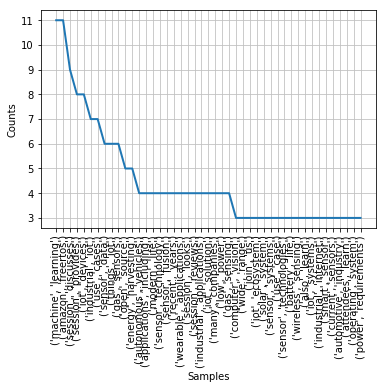

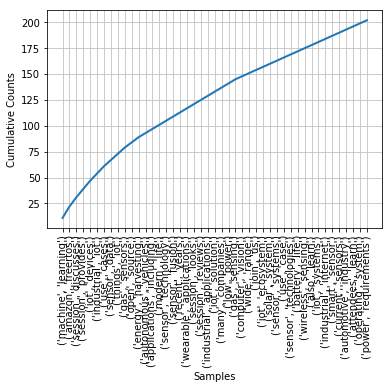

In [30]:
totBigrams = []
for sID in list(sessAbstractsDict.keys()):
    bigramList = sessAbstractsDict[sID]['sessAbstractBigrams']
    for bgram in bigramList:
        if bgram[0] not in stop_words and bgram[1] not in stop_words:
            totBigrams = totBigrams + [bgram]

fDistBigrams = FreqDist(totBigrams)
print("Number of Session Abstracts:", len(sessAbstractsDict))
print('')
print('Total Bigrams:', len(totBigrams))
print('')
print('Average Number of Bigrams/Abstract:',round(len(totBigrams)/len(sessAbstractsDict),2))
print('')
print('Total Vocabulary (Unique Bigrams):', len(fDistBigrams))
print('')
print('45 Most Common bigrams:', fDistBigrams.most_common(45))
print('')

cnt = 0
cutoff = 1
for lemma, count in fDistBigrams.items(): 
    if count == cutoff:
        cnt += count
print('Number of Bigrams with Frequencies equal to',cutoff,':', cnt, ' % of total:', round(100*cnt/len(totBigrams),2))
print('')
fDistBigrams.plot(45)
fDistBigrams.plot(45, cumulative=True)

For the corpus of abstracts, the frequency distribution of the bigrams has the same basic shape as the frequency distribution of the lemmas, i.e. skewed toward the most common bigrams. What differs is the magnitudes of the various frequencies.

For the entire corpus there were 3512 bigrams. While the most frequent bigrams were 'machine learning' and 'amazon freertos' with 11 occurrence each, the bigrams containing either of the lemmas 'sensor/sensing' and 'iot' seem to dominate with a combined frequency of 33 and 31, respectively. Unlike the lemmas, the 45 most common bigrams only account for 6% (~200/3512) of the total bigrams in the corpus. Similarly, the 200 most common bigrams only account for 15% (~550/3512). In fact, the corpus of bigrams is dominated by those that only appear 1X with ~80% of the bigrams falling in this category.

Overall, if you looked at the bigrams, you'd certainly understand that this is a conference about sensors. However, from a modeling perspective the addition of bigrams help that much in understanding the major underlying concepts and topics. The same is true for the trigrams.

<a class="anchor" id="freq dist trigrams"></a>
<h5>>Frequency Distribution of triagrams</h5>
* [Return to TOC](#toc)

In [31]:
totTrigrams = []
for sID in list(sessAbstractsDict.keys()):
    TrigramList = sessAbstractsDict[sID]['sessAbstractTrigrams']
    for tgram in TrigramList:
        if tgram[0] not in stop_words and tgram[2] not in stop_words:
            totTrigrams = totTrigrams + [tgram]

fDistTrigrams = FreqDist(totTrigrams)
print("Number of Session Abstracts:", len(sessAbstractsDict))
print('')
print('Total Trigrams:', len(totTrigrams))
print('')
print('Average Number of Trigrams/Abstract:',round(len(totTrigrams)/len(sessAbstractsDict),2))
print('')
print('Total Vocabulary (Unique Trigrams):', len(fDistTrigrams))
print('')
print('45 Most Common Trigrams:', fDistTrigrams.most_common(45))
print('')

cnt = 0
cutoff = 2
for trigrams, count in fDistTrigrams.items(): 
    if count == cutoff:
        cnt += count
print('Number of Trigrams with freq less than',cutoff,':', cnt, ' % of total:', round(100*cnt/len(totTrigrams),2))
print('')


Number of Session Abstracts: 132

Total Trigrams: 3903

Average Number of Trigrams/Abstract: 29.57

Total Vocabulary (Unique Trigrams): 3762

45 Most Common Trigrams: [(('internet', 'of', 'things'), 10), (('applications', 'this', 'session'), 5), (('attendees', 'will', 'learn'), 4), (('search', 'for', 'modern'), 3), (('symposium', 'will', 'provide'), 3), (('end', 'to', 'end'), 3), (('root', 'of', 'trust'), 3), (('flexible', 'fingerprint', 'sensors'), 3), (('sensing', 'and', 'control'), 3), (('ho', 'chi', 'minh'), 3), (('chi', 'minh', 'city'), 3), (('provide', 'an', 'overview'), 3), (('bluetooth', 'connectivity', 'models'), 3), (('blockchain', 'of', 'food'), 3), (('network', 'service', 'provider'), 3), (('learning', 'and', 'ai'), 2), (('mems', 'and', 'sensor'), 2), (('machine', 'learning', 'techniques'), 2), (('around', 'the', 'world'), 2), (('industries', 'this', 'session'), 2), (('answer', 'these', 'questions'), 2), (('roots', 'of', 'trust'), 2), (('element', 'of', 'basic'), 2), (('iot

The key finding for the frequency distribution of trigrams is that lexical diversity of the trigrams is very close to 1.0,  meaning that 93% of the trigrams (=3646/3762) only occur 1X in the corpus. When you add those that occurred 2Xs, it's 98%.  Basically, it is difficult to isolate any particular trigrams that represent the bulk of the conference content.

<a class="anchor" id="next steps"></a>
<h4>Next steps in the Analysis</h4>
* [Return to TOC](#toc)

The next step in the analysis is to utilize the NLTK textual analysis as a base for topic detection -- where the topics are basically broader categories that represent the major themes in the conference.  Given the above results, the start for the Topic detection will be a document-term matrix where the documents are the abstracts, the terms are the top 200 lemmas, and the cell values for any abstract-lemma combination is a normalized frequency indicating the relative number of times the lemma occurred in the designated abstract. Essentially, each row of the matrix is a BOWs for an abstract containing based on the relative frequency of occurrence for each of the top 200 lemmas. What is meant by the term 'relative' will be explained in the 'Topic Analysis' notebook. This notebook is also provided in this repository.

<a class="anchor" id="lemma dictionary"></a>
<h4>Lemma Dictionary for the Next Steps</h4>
* [Return to TOC](#toc)

To jump start the process of Topic Analysis, we'll create a dictionary containing both the lemmas and the associated 'bag of lemmas' for each session and store the dictionary in a JSON file. The code for writing out the file is straightfoward.

In [32]:
sessLemmasDict = {}
for ky in list(sessAbstractsDict.keys()):
   sessLemmasDict[ky] = {}
   sessLemmasDict[ky]['sessLemmas'] = sessAbstractsDict[ky]['sessAbstractLemmas']
   sessLemmasDict[ky]['sessLemmaBOW'] = sessAbstractsDict[ky]['sessAbstractLemmaBOW']

sysPath = 'c:/users/davek/'
jsonFile = sysPath + 'sessAbstractsDict.json'

jsonStr = json.dumps(sessLemmasDict, sort_keys=False, indent=2, separators=(',', ': '), ensure_ascii=False) 

with open(jsonFile, 'w') as f:
   f.write(jsonStr)

226523